In [ ]:
# !pip install pyarrow
# !pip install fastparquet 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importing packages, data, and preprocessing

In [2]:
# importing packages

import warnings
warnings.filterwarnings('ignore')
import sklearn

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np
import pandas as pd

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:.4f}'.format

In [3]:
# reading data

total_df = pd.read_parquet('data/total_df.parquet', engine = 'pyarrow') 

total_df = total_df[total_df['year'] != 2021] # we will not be using 2021 because the data is flawed and incomplete
print(total_df.shape)

(8406174, 38)


In [ ]:
# setting numerical columns and categorical columns

numerical_columns = []
for column in total_df.columns:
    if (total_df[column].dtypes == 'float') | (total_df[column].dtypes == 'int32') | (total_df[column].dtypes == 'int64'):
        numerical_columns.append(column)

# these are the numerical columns that we will actually use 
selected_numerical_columns = ['m (kg)','W (mm)',  'At1 (mm)', 'At2 (mm)', 'ec (cm3)', 'ep (KW)'] 

# we are not using 'year' as a feature. the reason for that is when we later predict future 
# Co2 emission of a car, the car's data can be from 2023, for example, and the 2023 isn't in the 
# feature category

categorical_columns = []

for column in total_df.columns.difference(numerical_columns):
    if total_df[column].nunique() <= 60:  
        categorical_columns.append(column)  

# these are the categorical columns that we will actually use 
selected_categorical_columns = ['Ct', 'Cr', 'Mp', 'Ft', 'Fm', 'Country']

all_year = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020] # we will not be using 2021

In [ ]:
# this is a function that returns linegraph from Co2 emission dataframes

def linegraph(df):
    df = df.T
    df.columns = df.iloc[0]
    df = df.drop(df.index[0])

    fig = plt.figure()
    plt.figure(figsize=(10, 6))

    for column in df.columns:
        plt.plot(df.index, df[column], label=column)

    plt.legend()
    return fig

### Overall Co2 Emission Trend analysis 
- how did average Co2 emission of a car changed overtime?

<AxesSubplot:xlabel='year'>

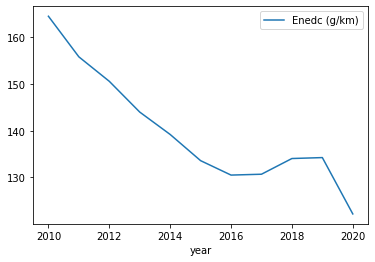

In [ ]:
pd.DataFrame(total_df.groupby(by=['year'])['Enedc (g/km)'].mean()).plot()

#### Total Cars Analysis

- Let's look at top 10 most registered cars and their average Co2 Emission each year

In [ ]:
emission_df = pd.DataFrame(columns = ['Cn']) # car model name columns : Cn
emission_df[[all_year]] = None

for name in total_df['Cn'].value_counts()[:10].index:

    tmp_dict = dict()
    tmp_dict['Cn'] = name
    for year in all_year:
        mean_val = total_df.loc[(total_df['Cn'] == name) & (total_df['year'] == year), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

emission_df

,Cn,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,golf,140.5576,138.1718,135.4521,122.2840,118.1535,115.3769,116.9190,118.2798,114.5991,117.1591,107.1357
1,octavia,148.8146,145.5858,143.5089,123.8304,118.2391,116.8709,115.5934,118.3027,117.1314,119.7076,106.8117
2,tiguan,179.3813,168.0802,164.5616,161.0738,156.4006,152.4199,144.5186,145.6141,139.8378,142.0567,139.4931
3,focus,151.0075,135.6692,128.2677,124.8789,123.5457,116.3680,116.1411,116.5091,114.8430,117.4081,109.6061
4,passat,154.4268,142.5878,141.4215,138.1356,135.6382,121.7890,120.4161,121.4675,121.0457,121.0982,106.1050
5,superb,166.1037,162.6720,160.1688,151.5879,142.7532,127.3962,121.6736,125.4817,126.1148,126.1830,99.6088
6,kodiaq,NaN,NaN,NaN,NaN,NaN,NaN,176.5294,149.7395,143.8658,146.0353,140.2360
7,polo,125.4525,121.0097,121.0369,120.5941,110.7834,104.9523,105.5766,107.9891,105.3173,109.5941,109.9396
8,karoq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126.7849,125.4326,129.7223,125.3184
9,caddy,163.4431,155.8373,155.1328,154.7387,153.8410,143.5704,130.0230,131.0251,138.9107,141.9672,139.5457


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

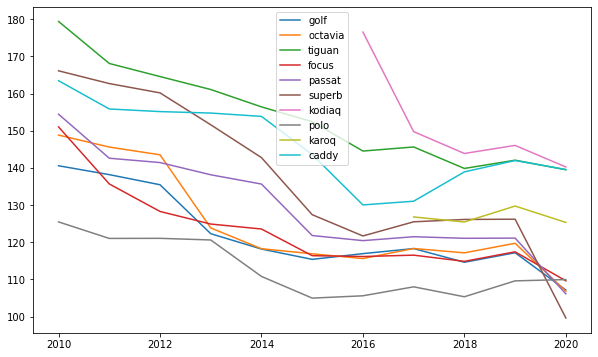

In [ ]:
linegraph(emission_df)

##### Small Cars and Big Cars
- How about when we focus on big and small cars seperately?
- let's divide the cars by engine capacity (proxy for size) and explore the Co2 Emission

In [ ]:
top_quartile = total_df['ec (cm3)'].describe()['75%']
bottom_quartile = total_df['ec (cm3)'].describe()['25%']

total_df_engine_top_quartile = total_df[total_df['ec (cm3)'] > top_quartile]
total_df_engine_bottom_quartile = total_df[total_df['ec (cm3)'] < bottom_quartile]

In [ ]:
# top 10 models that has top 25% engine capacity('ec (cm3)' column) and their average Co2 Emission each year

emission_df = pd.DataFrame(columns = ['Cn'])
emission_df[[all_year]] = None

for name in total_df_engine_top_quartile['Cn'].value_counts()[:10].index:
    tmp_dict = dict()
    tmp_dict['Cn'] = name
    for year in all_year:
        mean_val = total_df.loc[(total_df['Cn'] == name) & (total_df['year'] == year), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

emission_df

emission_df.set_index('Cn')

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Cn,,,,,,,,,,,
touareg,227.6313,202.6498,205.1413,203.1734,197.8566,183.1764,179.5752,188.9433,173.1071,175.5391,178.2292
cooper s,147.1548,141.4098,141.1858,148.3429,136.8261,134.4448,134.4227,133.2782,136.7873,134.8994,128.6765
x5 xdrive30d,206.1513,196.6421,195.1008,182.8161,163.3947,158.1720,157.0819,160.1779,168.8852,162.2784,159.7875
a6 avant,187.0308,176.9231,152.1874,150.2361,144.3132,135.9995,133.2028,133.9779,143.8244,138.2350,133.4056
v-klasse,NaN,NaN,NaN,181.6429,154.7689,161.1870,165.4735,165.8115,183.3271,172.0034,164.3760
mondeo,163.0845,156.2393,151.5714,145.4191,138.9249,129.6990,127.6453,127.8888,140.7699,138.8017,125.5679
q7,240.5911,214.9034,209.5063,205.9139,203.7600,168.2181,157.3953,154.6731,167.4688,175.9295,178.1608
530d xdrive,185.0909,159.2549,154.3632,152.4274,151.5354,153.3453,153.3569,141.9757,148.7586,151.4732,140.1450
q8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177.9219,180.3525,183.4979


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

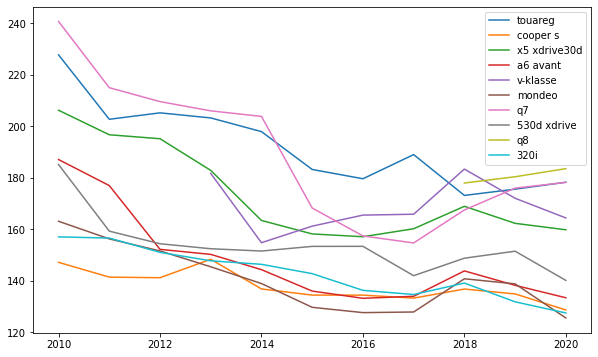

In [ ]:
linegraph(emission_df)

In [ ]:
# top 10 models that has bottom 25% engine capacity('ec (cm3)' column) and their average Co2 Emission each year

emission_df = pd.DataFrame(columns = ['Cn'])
emission_df[[all_year]] = None

for name in total_df_engine_bottom_quartile['Cn'].value_counts()[:10].index:
    tmp_dict = dict()
    tmp_dict['Cn'] = name
    for year in all_year:
        mean_val = total_df.loc[(total_df['Cn'] == name) & (total_df['year'] == year), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

emission_df

emission_df.set_index('Cn')

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Cn,,,,,,,,,,,
polo,125.4525,121.0097,121.0369,120.5941,110.7834,104.9523,105.5766,107.9891,105.3173,109.5941,109.9396
fiesta,127.3124,125.7460,121.4356,110.6759,107.5427,107.0227,107.6313,104.3499,113.0003,113.5911,102.8029
clio,133.2060,130.2328,123.4057,107.8062,106.1223,105.5492,105.1846,105.8551,108.7938,108.4285,103.4734
fabia,131.1654,122.0261,120.9621,120.0029,119.3883,107.3479,105.0818,106.1037,107.2464,106.5412,105.0407
golf,140.5576,138.1718,135.4521,122.2840,118.1535,115.3769,116.9190,118.2798,114.5991,117.1591,107.1357
megane,144.6821,140.3507,129.8417,122.9821,119.2944,118.0624,111.6259,110.8353,116.6242,123.0563,116.7649
focus,151.0075,135.6692,128.2677,124.8789,123.5457,116.3680,116.1411,116.5091,114.8430,117.4081,109.6061
corsa,126.2125,123.6981,123.4943,122.9339,121.5458,117.5058,113.2261,115.2373,126.6345,103.8647,87.8266
captur,NaN,NaN,NaN,109.0149,109.3821,108.8124,111.3421,112.8948,115.1145,120.7800,112.8882


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

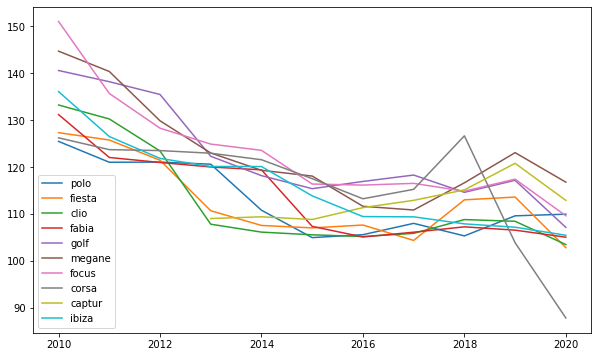

In [ ]:
linegraph(emission_df)

what happen to corsa? why the model's Co2 emission suddenly drops in 2019~2020?

let's look at Corsa's data

In [ ]:
df_corsa = total_df[total_df['Cn'] =='corsa']
tmp_df = df_corsa.groupby(by=['year', 'Ft'], as_index=False)['ID'].count()
tmp_df.pivot(*tmp_df)

Ft,diesel,electric,lpg,petrol
year,,,,
2010,994.0000,NaN,44.0000,2191.0000
2011,958.0000,NaN,52.0000,2436.0000
2012,897.0000,NaN,105.0000,2097.0000
2013,1037.0000,NaN,161.0000,2725.0000
2014,832.0000,NaN,199.0000,2375.0000
2015,346.0000,NaN,67.0000,884.0000
2016,135.0000,NaN,68.0000,478.0000
2017,105.0000,NaN,17.0000,232.0000
2018,32.0000,NaN,3.0000,444.0000


corsa's diesel model has lower Co2 emission compared to petrol model on average. (101 vs 113)
after 2017, the ratio of diesel to petrol drops from 40~50% to around 10%.
This should, in theory, increase the average Co2 emission of the model.

however, the average Co2 emission drops in 2019, and 2020 singnificantly. the reasons are 

1. In 2019, vauxhall launched a new model of corsa that significantly reduces Co2 emission. This is shown in the data where
Co2 emission of petrol model decreses from 128 in 2018 to 105 in 2019.(technology solves a problem, once again)
It can also be found in the following article : https://www.fleetnews.co.uk/news/manufacturer-news/2019/06/26/vauxhall-reveals-new-corsa-with-petrol-and-diesel-engines

2. In 2020, a large number of electric version of corsa are registered which lowers the average Co2 emssion significantly once again 


##### Detailed Trend Analysis

the overall trend of average Co2 Emission can be summarized to 3 stages

1. 2010 ~ 2015 : rapid decrease
2. 2016 ~ 2018 : stagnation or slight increase
3. 2019 ~ 2020 : slight decrease




1. 2010 ~ 2015 : rapid decrease

Euro 6 standard was introduced in 2015 september for most new registrations (2014 september for new approvals). 
In order to meet the regulation, the car manufacturers continued to improve the Co2 emission of each model.
The first phase shows the decrease of average Co2 emission of each model due to the effort

2. 2016 ~ 2018 : stagnation or slight increase

We see stagnation or slight increase of average Co2 Emission of cars. This is mainly due to the change in the ratio of diesel and petrol cars. When we look at the data below, the average Co2 emission of a car continues to decrease over time regardless of its fuel type (there is a slight increase in 2019 but it's negligible)

However, there is an increase of the ratio of petrol cars and decrease of diesel cars. Since in this data, petrol cars have higher Co2 emission, the increase of petrol cars causes the increase of average Co2 emission of total cars.

So, why did diesel cars decrease during this period? There may be many reasons such as regulations, but I would like to point out (1) the notorious "Dieselgate" happened in late 2015 so many people avoided diesel cars (2) gasoline prices were relatively low during this period so people were less burdened to drive petrol cars(petrol is more expensive than diesel in general)


<AxesSubplot:xlabel='year'>

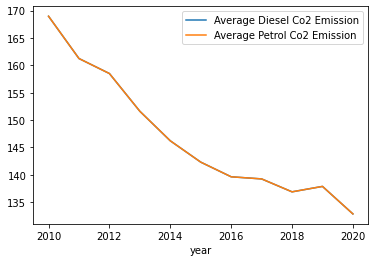

In [ ]:
df_diesel = total_df[total_df['Ft'] == 'diesel']
df_petrol = total_df[total_df['Ft'] == 'petrol']

fueltype_co2emission = pd.DataFrame(df_petrol.groupby(by='year')['Enedc (g/km)'].mean())
fueltype_co2emission.columns = ['Average Diesel Co2 Emission']
fueltype_co2emission['Average Petrol Co2 Emission'] = df_petrol.groupby(by='year')['Enedc (g/km)'].mean().values

fueltype_co2emission['diesel car ratio'] = (df_diesel.groupby(by='year')['ID'].count() / total_df.groupby(by='year')['ID'].count()).values
fueltype_co2emission['petrol car ratio'] = (df_petrol.groupby(by='year')['ID'].count() / total_df.groupby(by='year')['ID'].count()).values

fueltype_co2emission[['Average Diesel Co2 Emission', 'Average Petrol Co2 Emission']].plot()

<AxesSubplot:xlabel='year'>

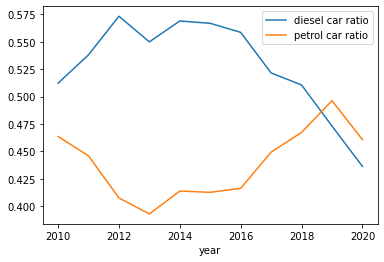

In [ ]:
fueltype_co2emission[[ 'diesel car ratio', 'petrol car ratio']].plot()

3. 2019 ~ 2020 : decrease again

The third phase's slight decrease can be attributed to mostly 2 factors. 

(1) electric cars : by 2020, electric and petrol-electric cars are added to the data. 
Since these types has 0 or very low Co2 emission, the average Co2 emission of a car decreases.

(2) improvement in technology : Aside from the electric cars, existing diesel and petrol models also improves in terms of Co2 emission.
As can be seen from the below data, most models experience the reduction of Co2 emission in 2020 compared to 2018. 
This means the companies launched a new version of the models with better Co2 emission.
The example of corsa mentioned above is a good example of it

In [ ]:
emission_df = pd.DataFrame(columns = ['Cn'])
emission_df[[2018, 2019, 2020]] = None

for name in total_df['Cn'].value_counts()[:10].index:

    tmp_dict = dict()
    tmp_dict['Cn'] = name
    for year in [2018, 2019, 2020]:
        mean_val = total_df.loc[(total_df['Cn'] == name) & (total_df['year'] == year) & (total_df['Ft'] =='diesel'), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

print("Co2 Emission of top 10 car's diesel models")

emission_df

Co2 Emission of top 10 car's diesel models


,Cn,2018,2019,2020
0,golf,111.5972,113.7774,105.5566
1,octavia,113.4976,117.5375,104.6058
2,tiguan,136.4679,138.8300,137.4533
3,focus,106.4328,107.8117,103.7567
4,passat,121.3278,121.7649,116.7178
5,superb,122.8214,120.9935,114.8987
6,kodiaq,142.4200,144.6739,140.1940
7,polo,100.0153,100.4421,100.5344
8,karoq,125.8024,130.9670,127.6445
9,caddy,139.6394,144.5078,139.0225


In [ ]:
emission_df = pd.DataFrame(columns = ['Cn'])
emission_df[[2018, 2019, 2020]] = None

for name in total_df['Cn'].value_counts()[:10].index:

    tmp_dict = dict()
    tmp_dict['Cn'] = name
    for year in [2018, 2019, 2020]:
        mean_val = total_df.loc[(total_df['Cn'] == name) & (total_df['year'] == year) & (total_df['Ft'] =='petrol'), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

print("Co2 Emission of top 10 car's petrol models")

emission_df

Co2 Emission of top 10 car's petrol models


,Cn,2018,2019,2020
0,golf,120.0906,124.4291,116.8231
1,octavia,121.6480,123.5039,114.7977
2,tiguan,149.0325,147.6901,142.2074
3,focus,119.5431,122.2317,113.1101
4,passat,128.7779,131.5523,129.7321
5,superb,137.3144,138.7410,133.6446
6,kodiaq,148.3178,148.6366,140.3210
7,polo,107.4664,111.8339,111.3850
8,karoq,125.1941,128.8105,123.5285
9,caddy,140.9102,140.7780,143.2668


#### (sidenote) Diesel vs Petrol

In this data, for the most car models, diesel has lower Co2 emission compared to petrol.
This might be interpretted as diesel making less pollution than petrol, but that's not the case.abs
While diesel indeed has lower Co2 emission compared to petrol, diesel emits more fine particles and 
other harmful materials such as NoX. 

This data shouldn't be interpretted as Diesel vs Petrol, as it only reflects "Co2" side 
of pollution

more information can be found here: https://youmatter.world/en/diesel-or-petrol-what-pollutes-more/

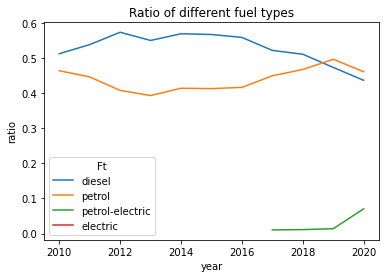

In [ ]:
ft_df = pd.DataFrame(total_df.groupby(by=['year', 'Ft'])['ID'].count() / total_df.groupby(by=['year'])['ID'].count()).reset_index()

ax = sns.lineplot(x = 'year', y = 'ID', hue='Ft', data=ft_df[ft_df['ID'] > 0.01])

ax.set( ylabel='ratio')
plt.title('Ratio of different fuel types')
plt.show()

#### Co2 Emission Winner
- which companies and models reduced the Co2 emission the most?

##### Which models reduced the Co2 emission the most?

First, let's see which petrol models reduced their Co2 emission the most!

In [ ]:
# df_diesel = total_df[total_df['Ft'] == 'diesel']
# df_petrol = total_df[total_df['Ft'] == 'petrol']

tmp_dict = dict()
min_year_list = []
max_year_list = []

for model in df_petrol['Cn'].value_counts()[:50].index:
    model_year = df_petrol.loc[df_petrol['Cn'] == model, 'year'].unique()
    min_year = model_year.min()
    max_year = model_year.max()
    min_year_list.append(min_year)
    max_year_list.append(max_year)

    min_year_avg = df_petrol.loc[(df_petrol['Cn']==model)&(df_petrol['year']==min_year), 'Enedc (g/km)'].mean()
    max_year_avg = df_petrol.loc[(df_petrol['Cn']==model)&(df_petrol['year']==max_year), 'Enedc (g/km)'].mean()

    reduction_percentage = np.round((min_year_avg - max_year_avg) / min_year_avg, 3)

    tmp_dict[model] = reduction_percentage

reduction_df = pd.DataFrame.from_dict(tmp_dict, orient='index').reset_index()
reduction_df.rename(columns={"index": "model", 0:"reduction"}, inplace=True)
reduction_df['min_year'] = min_year_list
reduction_df['max_year'] = max_year_list
reduction_df.sort_values(by='reduction', ascending=False, inplace=True)

reduction_df.head()

,model,reduction,min_year,max_year
45,kuga,0.4400,2010,2020
48,x1 sdrive18i,0.3550,2010,2020
1,focus,0.3540,2010,2020
27,308,0.3520,2010,2020
13,astra,0.3190,2010,2020


According to the data, following 5 petrol models decreased their Co2 emission the most

- kuga(ford) : 44% over 10 years

- x1 sdrive18i(bmw) : 35% over 10 years

- focus(ford, ford-volve) : 35% over 10 years

- 308(opel) : 35% over 10 years

- astra(gm, opel) : 31% over 10 years

***************** 

How about diesel models?

In [ ]:
tmp_dict = dict()
min_year_list = []
max_year_list = []

for model in df_diesel['Cn'].value_counts()[:50].index:
    model_year = df_diesel.loc[df_diesel['Cn'] == model, 'year'].unique()
    min_year = model_year.min()
    max_year = model_year.max()
    min_year_list.append(min_year)
    max_year_list.append(max_year)

    min_year_avg = df_diesel.loc[(df_diesel['Cn']==model)&(df_diesel['year']==min_year), 'Enedc (g/km)'].mean()
    max_year_avg = df_diesel.loc[(df_diesel['Cn']==model)&(df_diesel['year']==max_year), 'Enedc (g/km)'].mean()

    reduction_percentage = np.round((min_year_avg - max_year_avg) / min_year_avg, 3)

    tmp_dict[model] = reduction_percentage

reduction_df = pd.DataFrame.from_dict(tmp_dict, orient='index').reset_index()
reduction_df.rename(columns={"index": "model", 0:"reduction"}, inplace=True)
reduction_df['min_year'] = min_year_list
reduction_df['max_year'] = max_year_list
reduction_df.sort_values(by='reduction', ascending=False, inplace=True)

reduction_df.head()

,model,reduction,min_year,max_year
26,5008,0.2770,2010,2020
17,308,0.2750,2010,2020
6,a4 avant,0.2730,2010,2020
25,a5 sportback,0.2720,2010,2020
10,a6 avant,0.2650,2010,2020


According to the data, following 5 diesel models decreased their Co2 emission the most

- 5008(opel) : 44% over 10 years

- 308(opel) : 35% over 10 years

- a4 avant(vw) : 35% over 10 years

- a5 sportback(vw) : 35% over 10 years

- a6 avant(vw) : 31% over 10 years

Well done Volkswagen!! (or did you...?)

##### Which brands reduced the Co2 emission the most?

Petrol cars

In [ ]:
tmp_dict = dict()
min_year_list = []
max_year_list = []

for company in df_petrol['Mp'].value_counts()[:30].index:
    model_year = df_petrol.loc[df_petrol['Mp'] == company, 'year'].unique()
    min_year = model_year.min()
    max_year = model_year.max()
    min_year_list.append(min_year)
    max_year_list.append(max_year)

    min_year_avg = df_petrol.loc[(df_petrol['Mp']==company)&(df_petrol['year']==min_year), 'Enedc (g/km)'].mean()
    max_year_avg = df_petrol.loc[(df_petrol['Mp']==company)&(df_petrol['year']==max_year), 'Enedc (g/km)'].mean()

    reduction_percentage = np.round((min_year_avg - max_year_avg) / min_year_avg, 3)

    tmp_dict[company] = reduction_percentage

reduction_df = pd.DataFrame.from_dict(tmp_dict, orient='index').reset_index()
reduction_df.rename(columns={"index": "company", 0:"reduction"}, inplace=True)
reduction_df['min_year'] = min_year_list
reduction_df['max_year'] = max_year_list
reduction_df.sort_values(by='reduction', ascending=False, inplace=True)

reduction_df.head()

,company,reduction,min_year,max_year
6,bmw,0.2300,2010,2020
29,suzuki,0.2250,2011,2020
0,vw group pc,0.1870,2011,2019
2,bmw group,0.1550,2012,2019
3,psa-opel,0.1340,2018,2020


According to the data, following 4 companies decreased the average petrol Co2 emission the most

- bmw
- suzuki
- vw
- psa-opel

Diesel cars

In [ ]:
tmp_dict = dict()
min_year_list = []
max_year_list = []

for company in df_diesel['Mp'].value_counts()[:30].index:
    model_year = df_diesel.loc[df_diesel['Mp'] == company, 'year'].unique()
    min_year = model_year.min()
    max_year = model_year.max()
    min_year_list.append(min_year)
    max_year_list.append(max_year)

    min_year_avg = df_diesel.loc[(df_diesel['Mp']==company)&(df_diesel['year']==min_year), 'Enedc (g/km)'].mean()
    max_year_avg = df_diesel.loc[(df_diesel['Mp']==company)&(df_diesel['year']==max_year), 'Enedc (g/km)'].mean()

    reduction_percentage = np.round((min_year_avg - max_year_avg) / min_year_avg, 3)

    tmp_dict[company] = reduction_percentage

reduction_df = pd.DataFrame.from_dict(tmp_dict, orient='index').reset_index()
reduction_df.rename(columns={"index": "company", 0:"reduction"}, inplace=True)
reduction_df['min_year'] = min_year_list
reduction_df['max_year'] = max_year_list
reduction_df.sort_values(by='reduction', ascending=False, inplace=True)

reduction_df.head()

,company,reduction,min_year,max_year
26,honda motor europe ltd,0.3790,2011,2019
2,daimler ag,0.1760,2011,2019
6,bmw,0.1710,2010,2020
8,general motors,0.1120,2012,2017
16,kia,0.1090,2014,2020


According to the data, following 5 companies decreased the average diesel Co2 emission the most

- honda
- daimler
- bmw
- gm
- kia

### Country comparison analysis

- Let's narrow down the analysis to country level and compare

- We will focus on 4 countries(Germany, France, Great Britain, Italy) because these countries have the most data

##### Overall trends of the 4 countries

Let's see the average Co2 emssion of a car for each country overtime.

<Figure size 432x288 with 0 Axes>

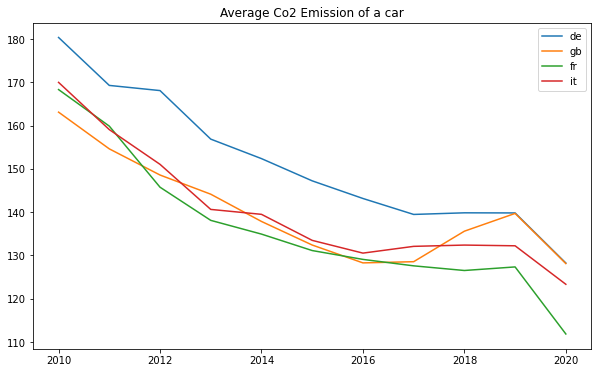

In [ ]:
fig = plt.figure()
plt.figure(figsize=(10, 6))

country_list = ['de', 'gb', 'fr', 'it']

for country in country_list:

    country_df = total_df[total_df['Country']==country]
    data = country_df.groupby('year')['Enedc (g/km)'].mean()
    plt.plot(data.index, data.values, label=country)

plt.legend()
plt.title('Average Co2 Emission of a car')
plt.show()

2 characteristics are shown.

(1) Germany constantly shows higher average Co2 emission than other count

(2) Great Britain shows significant increase in average Co2 emission in 2017~2019

We will answer these questions in the Country Analysis Summary section

In [ ]:
# Creating dataframes for the summary
country_most_model = pd.DataFrame()
country_most_brand = pd.DataFrame()
country_dp_ratio = pd.DataFrame()

#### Germany

In [ ]:
# Germany data only

country_name = 'de'
country_df = total_df[total_df['Country'] == country_name]

##### Total cars, big vs small cars analysis

In [ ]:
# top 10 most registered cars and their average Co2 Emission each year

emission_df = pd.DataFrame(columns = ['Cn']) # car model name columns : Cn
emission_df[[all_year]] = None

for name in country_df['Cn'].value_counts()[:10].index:

    tmp_dict = dict()
    tmp_dict['Cn'] = name
    for year in all_year:
        mean_val = country_df.loc[(country_df['Cn'] == name) & (country_df['year'] == year), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

country_most_model[country_name] = emission_df['Cn']

emission_df

,Cn,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,golf,145.9367,139.9472,138.6263,130.3535,124.6683,121.8262,124.8586,123.1071,117.3074,120.3557,110.7105
1,tiguan,186.3291,172.1208,170.4333,165.6625,163.2215,160.3558,154.3011,149.7261,138.3297,144.4958,142.6330
2,focus,154.3494,142.6228,128.8741,126.9844,125.6849,120.2590,122.6503,123.3185,117.0767,119.8038,111.6520
3,passat,158.4972,146.6531,148.1044,143.6749,146.0127,128.9393,124.5525,125.8050,122.3028,123.8800,107.1906
4,octavia,153.2155,149.3645,151.8286,129.5282,119.7782,119.7762,118.5290,120.4682,119.0865,123.2493,107.9918
5,caddy,161.4851,157.7546,155.7053,155.4649,154.8392,145.3693,131.2358,132.1189,140.6983,141.9584,139.5862
6,a4 avant,NaN,NaN,NaN,141.0757,138.3256,133.8854,121.7034,120.5977,123.5520,128.7594,123.6497
7,v-klasse,NaN,NaN,NaN,181.6429,158.0696,160.9404,165.0723,164.9458,184.9456,170.6298,163.7476
8,polo,129.1143,121.7082,128.0863,125.0967,120.0417,108.3693,107.7665,114.8676,105.2804,109.6545,111.5478
9,touran,155.2510,143.8733,144.9177,143.7239,144.0788,140.9719,125.9530,126.9563,122.3748,125.4373,124.2261


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

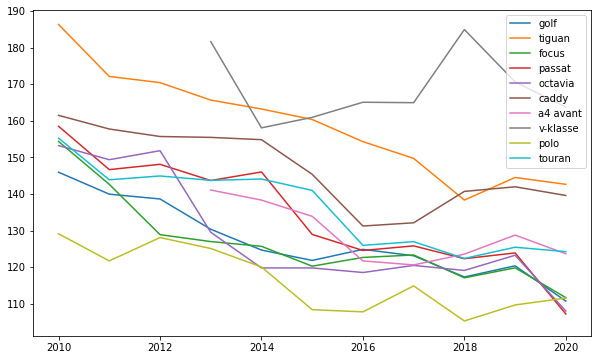

In [ ]:
linegraph(emission_df)

Above is the most registered models in Germany, and their average Co2 emission each year.

Top 5 models are 
- golf 
- tiguan
- focus
- passat
- octavia


Their average co2 emission trends
are similar to the overall pattern mentioned in the first part of the EDA

2 models shows V shape increase of Co2 emission in 2016~2018 period; caddy, and v-klasse.
They are both vans.

Below is the engine capacity(proxy for car size) distribution. 
We will conduct similar analysis on big(top 25%) and small(bottom 25%) cars seperately.

count   2303385.0000
mean       1926.1836
std         654.8809
min           0.0000
25%        1498.0000
50%        1968.0000
75%        1995.0000
max        9999.0000
Name: ec (cm3), dtype: float64


<AxesSubplot:>

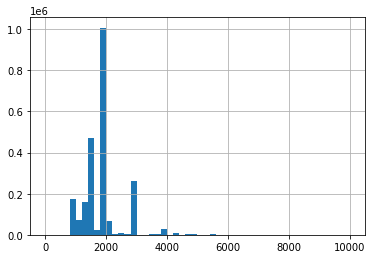

In [ ]:
print(country_df['ec (cm3)'].describe())
country_df['ec (cm3)'].hist(bins=50)

In [ ]:
top_quartile = country_df['ec (cm3)'].describe()['75%']
bottom_quartile = country_df['ec (cm3)'].describe()['25%']

country_df_engine_top_quartile = country_df[country_df['ec (cm3)'] > top_quartile]
country_df_engine_bottom_quartile = country_df[country_df['ec (cm3)'] < bottom_quartile]

In [ ]:
# top 10 models that has top 25% engine capacity('ec (cm3)' column) and their average Co2 Emission each year

emission_df = pd.DataFrame(columns = ['Cn'])
emission_df[[all_year]] = None

for name in country_df_engine_top_quartile['Cn'].value_counts()[:10].index:
    tmp_dict = dict()
    tmp_dict['Cn'] = name
    for year in all_year:
        mean_val = country_df.loc[(country_df['Cn'] == name) & (country_df['year'] == year), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

emission_df

,Cn,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,touareg,249.1800,210.2222,223.2523,213.3913,224.7609,208.9079,214.8800,228.5698,173.0356,176.5272,179.4812
1,a6 avant,NaN,NaN,NaN,152.7799,145.7492,138.1935,135.3595,134.6489,146.1606,141.3571,136.1006
2,v-klasse,NaN,NaN,NaN,181.6429,158.0696,160.9404,165.0723,164.9458,184.9456,170.6298,163.7476
3,530d xdrive,NaN,NaN,NaN,152.7097,152.1111,152.9667,150.6410,144.0632,149.4971,152.0339,140.8056
4,cooper s,NaN,NaN,NaN,147.2857,138.7015,135.4845,134.7767,135.9516,137.4233,135.8922,130.4037
5,sprinter,257.2138,248.6410,222.3417,211.1091,201.1941,198.8386,200.2231,201.9440,194.8639,195.0552,194.5277
6,x5 xdrive30d,NaN,NaN,NaN,186.7931,166.2927,160.3750,157.3659,NaN,NaN,162.1083,159.2617
7,q7,NaN,NaN,214.4730,208.6135,210.8947,179.4980,171.8252,155.9115,171.6682,175.6567,179.1348
8,vito tourer,NaN,NaN,NaN,NaN,156.0000,159.1833,162.6132,162.5611,177.2480,165.7217,159.7513
9,530d,NaN,NaN,149.0690,148.6769,144.7105,142.9167,141.5000,130.2706,138.8488,140.6018,130.0974


top 25% engine capacity cars


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

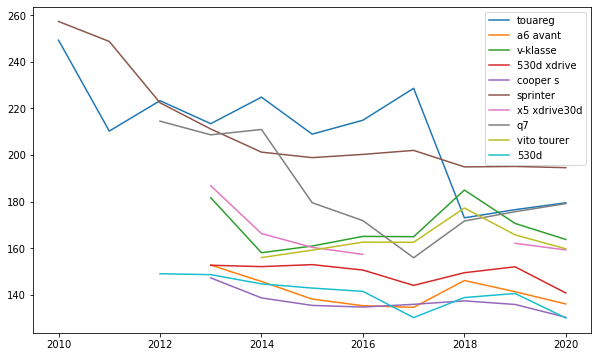

In [ ]:
print('top 25% engine capacity cars')

linegraph(emission_df)

In [ ]:
# top 10 models that has bottom 25% engine capacity('ec (cm3)' column) and their average Co2 Emission each year

emission_df = pd.DataFrame(columns = ['Cn'])
emission_df[[all_year]] = None

for name in country_df_engine_bottom_quartile['Cn'].value_counts()[:10].index:
    tmp_dict = dict()
    tmp_dict['Cn'] = name
    for year in all_year:
        mean_val = country_df.loc[(country_df['Cn'] == name) & (country_df['year'] == year), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

emission_df

,Cn,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,focus,154.3494,142.6228,128.8741,126.9844,125.6849,120.2590,122.6503,123.3185,117.0767,119.8038,111.6520
1,fiesta,122.8462,125.2991,117.8744,112.9422,107.0216,106.7231,111.9373,103.9803,114.5994,114.3360,103.7881
2,polo,129.1143,121.7082,128.0863,125.0967,120.0417,108.3693,107.7665,114.8676,105.2804,109.6545,111.5478
3,golf,145.9367,139.9472,138.6263,130.3535,124.6683,121.8262,124.8586,123.1071,117.3074,120.3557,110.7105
4,caddy,161.4851,157.7546,155.7053,155.4649,154.8392,145.3693,131.2358,132.1189,140.6983,141.9584,139.5862
5,corsa-e,NaN,NaN,NaN,NaN,117.3857,114.8648,115.7669,117.7954,132.2597,131.7614,131.0000
6,astra sports tourer,146.4512,NaN,NaN,134.1967,133.3842,135.8280,118.9158,113.7580,122.2015,124.3548,100.7781
7,fabia,132.7586,123.5987,130.0208,121.2267,120.9263,114.0136,105.8059,107.8593,107.8777,106.5205,105.0657
8,a 200,166.2632,NaN,NaN,131.9231,129.3818,127.7708,128.0800,126.1316,128.3048,125.8411,122.7531
9,crossland x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.0719,117.6024,113.8886,109.3791


bottom 25% engine capacity cars


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

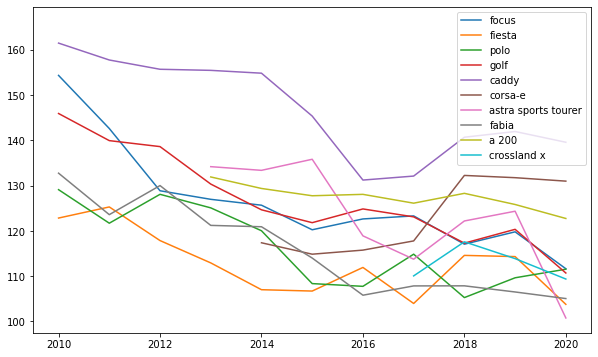

In [ ]:
print('bottom 25% engine capacity cars')

linegraph(emission_df)

When looking at more detailed data, the trend is less clear. However, we can still observe 
overall decrease in the average Co2 emission over time.

##### Brand analysis

- which brands were most registered in the country, and how's their Co2 emission?

In [ ]:
country_df['Mp'].value_counts()[:10]

vw group pc        578056
vw-saic            342195
daimler ag         299375
bmw group          245345
psa-opel           164258
mercedes-benz      141201
bmw                119881
ford-werke gmbh    113704
ford-volvo          66050
general motors      35339
Name: Mp, dtype: int64

In [ ]:
emission_df = pd.DataFrame(columns = ['Mp']) 
emission_df[[all_year]] = None

# for brand in country_df.loc[country_df['year']==2017, 'Mp'].value_counts()[:10].index:
for brand in country_df['Mp'].value_counts()[:10].index:

    tmp_dict = dict()
    tmp_dict['Mp'] = brand
    for year in all_year:
        mean_val = country_df.loc[(country_df['Mp'] == brand) & (country_df['year'] == year), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

country_most_brand[country_name] = emission_df['Mp']

emission_df

,Mp,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,vw group pc,NaN,164.5637,163.1023,153.9695,150.9079,142.8007,140.9848,131.9937,132.7185,137.9890,NaN
1,vw-saic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.4740
2,daimler ag,NaN,188.0703,176.4982,167.9185,162.0574,155.5249,154.4528,149.1433,157.6957,152.4812,NaN
3,bmw group,NaN,NaN,163.9237,156.8920,149.4445,143.6494,140.7824,136.7079,133.9275,137.1999,NaN
4,psa-opel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.9762,126.5214,111.6910
5,mercedes-benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134.0028
6,bmw,180.1905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.3156
7,ford-werke gmbh,NaN,165.9569,152.2559,151.5445,140.5466,135.6701,134.7510,133.7818,138.1903,136.9410,NaN
8,ford-volvo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.6274
9,general motors,NaN,NaN,294.2845,145.7549,144.4452,140.6124,132.9978,135.1462,NaN,NaN,NaN


As expected, German brands such as VW, daimler, and BMW are the most registered brands in Germany

##### Fuel type analysis

In germany, diesel is the most dominant fuel type, but the gap between diesel and petrol is decreaseing and almost minimal

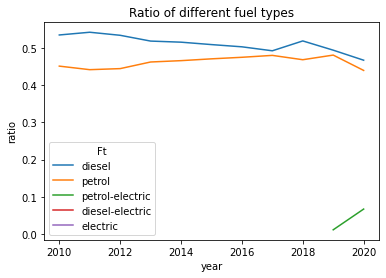

In [ ]:
ft_df = pd.DataFrame(country_df.groupby(by=['year', 'Ft'])['ID'].count() / country_df.groupby(by=['year'])['ID'].count()).reset_index()

country_dp_ratio[country_name] = ft_df.loc[ft_df['Ft']=='diesel', 'ID'].reset_index(drop=True) / ft_df.loc[ft_df['Ft']=='petrol', 'ID'].reset_index(drop=True)

ax = sns.lineplot(x = 'year', y = 'ID', hue='Ft', data=ft_df[ft_df['ID'] > 0.01])

ax.set( ylabel='ratio')
plt.title('Ratio of different fuel types')
plt.show()

#### Great Britain

In [ ]:
# GB data only

country_name = 'gb'
country_df = total_df[total_df['Country'] == country_name]

##### Total cars, big vs small cars analysis

In [ ]:
# top 10 most registered cars and their average Co2 Emission each year

emission_df = pd.DataFrame(columns = ['Cn']) # car model name columns : Cn
emission_df[[all_year]] = None

for name in country_df['Cn'].value_counts()[:10].index:

    tmp_dict = dict()
    tmp_dict['Cn'] = name
    for year in all_year:
        mean_val = country_df.loc[(country_df['Cn'] == name) & (country_df['year'] == year), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

country_most_model[country_name] = emission_df['Cn']

emission_df

,Cn,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,cooper,131.9464,131.1828,128.6719,140.0612,120.1596,116.7447,115.4747,110.8140,116.1786,124.2381,116.7059
1,unknown,188.8173,181.8107,178.7211,175.6964,157.9879,157.6686,172.0954,167.0392,NaN,NaN,NaN
2,cooper s,144.5577,139.2857,138.3235,148.5455,137.4337,135.2584,134.5938,137.7143,143.6749,137.4233,131.0936
3,megane,145.6154,141.8751,126.4218,117.6894,115.1137,116.6910,NaN,106.1351,116.1860,NaN,128.6571
4,clio,136.7374,138.1047,133.2930,110.5154,106.5569,106.4698,119.6667,104.9767,109.2664,NaN,103.2973
5,118i,NaN,NaN,176.0000,140.4756,134.6087,129.2192,122.2037,NaN,NaN,124.6815,116.8428
6,x5 xdrive30d,NaN,NaN,NaN,184.3548,162.2826,157.6250,156.8800,NaN,NaN,162.9962,159.0743
7,fiesta zetec,131.2085,127.8640,126.0436,113.6115,110.6244,107.6782,109.7284,107.9565,112.7121,113.7174,114.0000
8,megane scenic,156.4240,144.8051,126.9656,122.7248,122.7377,120.9946,NaN,NaN,NaN,NaN,NaN
9,320d,154.0000,109.0000,179.0000,127.0994,124.9268,122.2622,118.5891,NaN,NaN,119.9911,113.1489


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

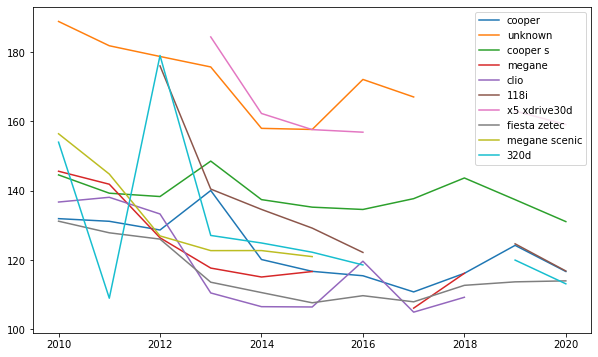

In [ ]:
linegraph(emission_df)

Above is the most registered models in Great Britain, and their average Co2 emission each year.

Top 5 models are 
- cooper 
- megane
- clio
- 118i
- x5 xdrive30d


Although there is a decreasing trend of average Co2 emission, there are certain outliers
that shows quite different movement with the trend. For example, 320d model shows fluctutation
during the earlt 2010s and many models are somewhat stagnant after 2012

Below is the engine capacity(proxy for car size) distribution. 
We will conduct similar analysis on big(top 25%) and small(bottom 25%) cars seperately.

count   764739.0000
mean      1916.1236
std        726.3961
min          0.0000
25%       1498.0000
50%       1968.0000
75%       1998.0000
max       9592.0000
Name: ec (cm3), dtype: float64


<AxesSubplot:>

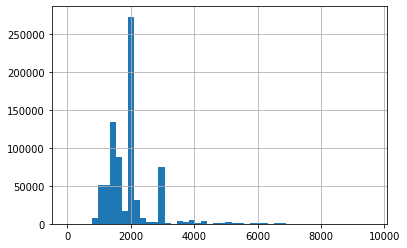

In [ ]:
print(country_df['ec (cm3)'].describe())
country_df['ec (cm3)'].hist(bins=50)

In [ ]:
top_quartile = country_df['ec (cm3)'].describe()['75%']
bottom_quartile = country_df['ec (cm3)'].describe()['25%']

country_df_engine_top_quartile = country_df[country_df['ec (cm3)'] > top_quartile]
country_df_engine_bottom_quartile = country_df[country_df['ec (cm3)'] < bottom_quartile]

In [ ]:
# top 10 models that has top 25% engine capacity('ec (cm3)' column) and their average Co2 Emission each year

emission_df = pd.DataFrame(columns = ['Cn'])
emission_df[[all_year]] = None

for name in country_df_engine_top_quartile['Cn'].value_counts()[:10].index:
    tmp_dict = dict()
    tmp_dict['Cn'] = name
    for year in all_year:
        mean_val = country_df.loc[(country_df['Cn'] == name) & (country_df['year'] == year), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

emission_df

,Cn,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,unknown,188.8173,181.8107,178.7211,175.6964,157.9879,157.6686,172.0954,167.0392,NaN,NaN,NaN
1,x5 xdrive30d,NaN,NaN,NaN,184.3548,162.2826,157.6250,156.8800,NaN,NaN,162.9962,159.0743
2,r rover sport hse dyn sdv6 a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202.0000,199.6275,201.3733,NaN
3,viano ambiente 2.2 cdi blue-cy,215.9286,215.0540,213.4252,212.4167,213.6693,214.0000,NaN,NaN,NaN,NaN,NaN
4,x5 m50d,NaN,NaN,NaN,190.7500,176.1579,173.4444,173.0000,NaN,NaN,179.5405,180.6451
5,range rover sport hse sdv6 a,NaN,230.0800,230.0000,212.0000,199.0000,187.9459,185.0000,189.8333,197.7085,197.0790,NaN
6,vito 113 cdi traveliner,199.0500,204.7308,202.3287,202.6250,202.9415,204.7143,NaN,NaN,NaN,NaN,NaN
7,911 carrera 4s s-a,NaN,NaN,215.5000,215.6000,213.0000,209.6250,190.2857,183.6000,186.0000,206.2862,206.7559
8,macan s s-a,NaN,NaN,NaN,NaN,207.0000,197.6000,206.7333,207.5556,208.0000,201.7600,202.5039
9,911 carrera s s-a,NaN,NaN,207.0000,207.1429,204.5000,195.8000,185.2222,177.7143,176.0000,206.0094,205.9588


top 25% engine capacity cars


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

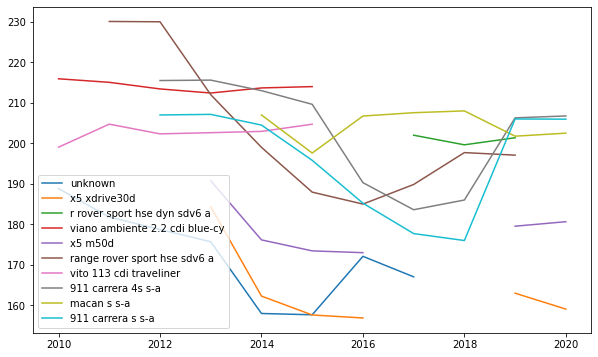

In [ ]:
print('top 25% engine capacity cars')

linegraph(emission_df)

In [ ]:
# top 10 models that has bottom 25% engine capacity('ec (cm3)' column) and their average Co2 Emission each year

emission_df = pd.DataFrame(columns = ['Cn'])
emission_df[[all_year]] = None

for name in country_df_engine_bottom_quartile['Cn'].value_counts()[:10].index:
    tmp_dict = dict()
    tmp_dict['Cn'] = name
    for year in all_year:
        mean_val = country_df.loc[(country_df['Cn'] == name) & (country_df['year'] == year), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

emission_df

,Cn,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,clio,136.7374,138.1047,133.2930,110.5154,106.5569,106.4698,119.6667,104.9767,109.2664,NaN,103.2973
1,megane,145.6154,141.8751,126.4218,117.6894,115.1137,116.6910,NaN,106.1351,116.1860,NaN,128.6571
2,fiesta zetec,131.2085,127.8640,126.0436,113.6115,110.6244,107.6782,109.7284,107.9565,112.7121,113.7174,114.0000
3,fiesta st-line x turbo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0000,111.7418,111.0572,110.7456
4,fiesta st-line turbo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0000,111.1980,110.4284,109.8935
5,fiat 500,NaN,108.9910,103.3463,104.4840,NaN,NaN,101.9706,NaN,NaN,NaN,NaN
6,captur,NaN,NaN,NaN,107.2241,107.4647,107.5593,95.0000,110.1889,113.3623,NaN,118.1636
7,fiesta titanium turbo,NaN,NaN,NaN,NaN,NaN,99.0000,99.0000,98.2258,108.6239,107.1405,103.6753
8,unknown,188.8173,181.8107,178.7211,175.6964,157.9879,157.6686,172.0954,167.0392,NaN,NaN,NaN
9,focus st-line x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.6000,120.5028,121.0049,112.5877


bottom 25% engine capacity cars


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

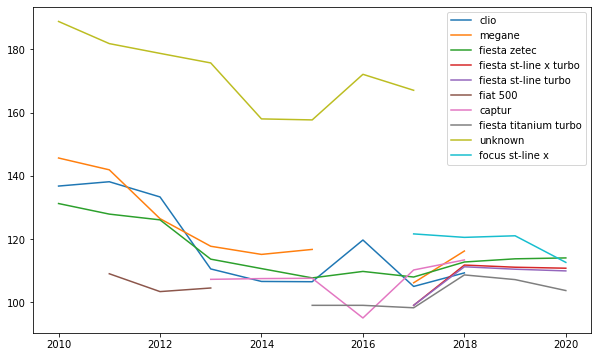

In [ ]:
print('bottom 25% engine capacity cars')

linegraph(emission_df)

The decrease is more apparent in bigger models than smaller ones.

##### Brand analysis

- which brands were most registered in the country, and how's their Co2 emission?

In [ ]:
country_df['Mp'].value_counts()[:10]

vw group pc                      148829
bmw group                         95028
ford-werke gmbh                   54181
daimler ag                        52304
vw-saic                           43976
tata motors jaguar land rover     37258
general motors                    32703
bmw                               31993
psa-opel                          26419
ford-volvo                        22233
Name: Mp, dtype: int64

In [ ]:
emission_df = pd.DataFrame(columns = ['Mp']) 
emission_df[[all_year]] = None

# for brand in country_df.loc[country_df['year']==2017, 'Mp'].value_counts()[:10].index:
for brand in country_df['Mp'].value_counts()[:10].index:

    tmp_dict = dict()
    tmp_dict['Mp'] = brand
    for year in all_year:
        mean_val = country_df.loc[(country_df['Mp'] == brand) & (country_df['year'] == year), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

country_most_brand[country_name] = emission_df['Mp']

emission_df

,Mp,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,vw group pc,NaN,155.9932,149.7092,144.4616,139.3866,130.0635,126.8270,126.8848,129.4460,135.3518,NaN
1,bmw group,NaN,NaN,150.4975,147.5124,141.9354,137.9558,133.6687,132.4850,125.9947,137.1678,NaN
2,ford-werke gmbh,NaN,137.6459,134.0789,133.3726,127.3593,124.1602,122.5300,127.0654,134.1545,131.4569,NaN
3,daimler ag,NaN,175.9814,170.4708,159.6257,160.0081,136.0958,131.6113,131.8416,153.0778,160.0353,NaN
4,vw-saic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.6577
5,tata motors jaguar land rover,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159.6151,173.5298,170.7323,NaN
6,general motors,NaN,NaN,137.1189,132.8387,130.2315,127.5135,122.6571,125.1897,NaN,NaN,NaN
7,bmw,163.6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.8923
8,psa-opel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.6271,119.0257,103.6790
9,ford-volvo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.0081


Other than German brands, we see ford, tata-motors, and GM in the top 10 brands

##### Fuel type analysis

In Great Britain, petrol overtook diesel as the most popular fuel type. And we see significant
increase in petrol-electric and electric types as well

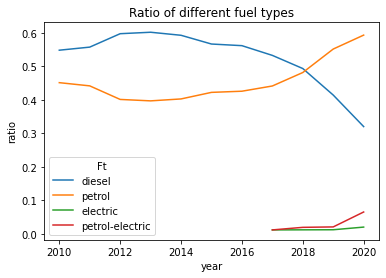

In [ ]:
ft_df = pd.DataFrame(country_df.groupby(by=['year', 'Ft'])['ID'].count() / country_df.groupby(by=['year'])['ID'].count()).reset_index()

country_dp_ratio[country_name] = ft_df.loc[ft_df['Ft']=='diesel', 'ID'].reset_index(drop=True) / ft_df.loc[ft_df['Ft']=='petrol', 'ID'].reset_index(drop=True)

ax = sns.lineplot(x = 'year', y = 'ID', hue='Ft', data=ft_df[ft_df['ID'] > 0.01])

ax.set( ylabel='ratio')
plt.title('Ratio of different fuel types')
plt.show()

#### France

In [ ]:
# France data only

country_name = 'fr'
country_df = total_df[total_df['Country'] == country_name]

##### Total cars, big vs small cars analysis

In [ ]:
# top 10 most registered cars and their average Co2 Emission each year

emission_df = pd.DataFrame(columns = ['Cn']) # car model name columns : Cn
emission_df[[all_year]] = None

for name in country_df['Cn'].value_counts()[:10].index:

    tmp_dict = dict()
    tmp_dict['Cn'] = name
    for year in all_year:
        mean_val = country_df.loc[(country_df['Cn'] == name) & (country_df['year'] == year), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

country_most_model[country_name] = emission_df['Cn']

emission_df

,Cn,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,308,147.1087,140.9259,139.1000,130.5980,115.1930,106.1791,102.0357,104.8484,109.0325,106.5824,100.3757
1,golf,137.7524,138.5914,132.6961,119.7832,118.8025,115.5525,116.2825,116.4861,111.3422,116.2097,104.6864
2,tiguan,176.2308,163.3827,154.6653,150.5745,150.1883,146.6220,140.8353,140.4589,136.0541,137.1546,132.2466
3,ds 7 crossback,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.2391,125.7512,120.2861,98.4536
4,classe c,173.0117,154.5990,148.8755,144.3457,126.2549,122.1162,127.7417,129.3563,133.5064,135.6260,NaN
5,3008,152.7931,141.9512,137.8741,133.1145,126.0462,118.8167,117.1609,112.7303,118.0463,116.6651,100.8186
6,focus,150.1954,135.3855,127.5490,123.6164,121.1768,117.2230,114.5126,113.6154,112.6935,115.9043,107.0488
7,fiesta,124.5135,123.0000,118.7526,109.7768,105.5672,105.1697,104.8268,102.7346,112.8312,113.0417,101.1063
8,serie x,209.5656,193.1761,181.2905,NaN,NaN,156.0000,NaN,146.6576,137.9741,NaN,NaN
9,5008,153.8095,148.5200,147.3929,142.0745,135.1616,122.9479,119.3654,114.6800,117.4588,117.9493,113.4321


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

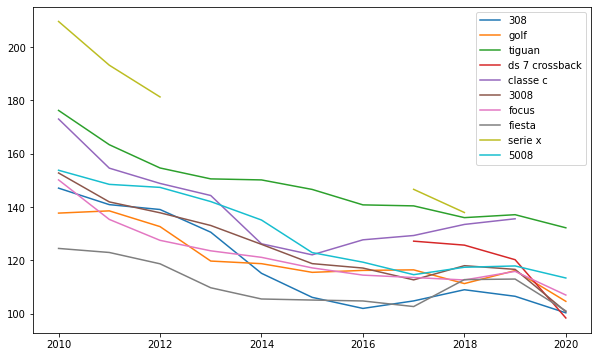

In [ ]:
linegraph(emission_df)

Above is the most registered models in France, and their average Co2 emission each year.

Top 5 models are 
- 308
- golf
- tiguan
- ds7 crossback
- classe c


In Frace, we see a definite overall decreasing trend over all models.

Below is the engine capacity(proxy for car size) distribution. 
We will conduct similar analysis on big(top 25%) and small(bottom 25%) cars seperately.

count   671731.0000
mean      1755.9398
std        590.0973
min          0.0000
25%       1461.0000
50%       1598.0000
75%       1995.0000
max       8285.0000
Name: ec (cm3), dtype: float64


<AxesSubplot:>

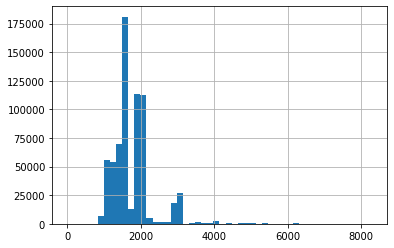

In [ ]:
print(country_df['ec (cm3)'].describe())
country_df['ec (cm3)'].hist(bins=50)

In [ ]:
top_quartile = country_df['ec (cm3)'].describe()['75%']
bottom_quartile = country_df['ec (cm3)'].describe()['25%']

country_df_engine_top_quartile = country_df[country_df['ec (cm3)'] > top_quartile]
country_df_engine_bottom_quartile = country_df[country_df['ec (cm3)'] < bottom_quartile]

In [ ]:
# top 10 models that has top 25% engine capacity('ec (cm3)' column) and their average Co2 Emission each year

emission_df = pd.DataFrame(columns = ['Cn'])
emission_df[[all_year]] = None

for name in country_df_engine_top_quartile['Cn'].value_counts()[:10].index:
    tmp_dict = dict()
    tmp_dict['Cn'] = name
    for year in all_year:
        mean_val = country_df.loc[(country_df['Cn'] == name) & (country_df['year'] == year), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

emission_df

,Cn,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,classe glc,NaN,NaN,NaN,NaN,NaN,143.5714,140.4518,140.4068,165.8780,160.7907,155.0000
1,classe c,173.0117,154.5990,148.8755,144.3457,126.2549,122.1162,127.7417,129.3563,133.5064,135.6260,NaN
2,classe e,175.7703,165.4567,155.1345,148.3829,144.1488,139.4124,127.6356,132.2077,138.2748,130.8801,NaN
3,508,138.4375,133.1667,129.0974,124.6272,121.0927,116.1103,112.4631,108.4430,117.5988,113.5855,94.4192
4,cooper s,NaN,NaN,NaN,156.1429,138.1972,135.4674,135.5119,NaN,NaN,131.6025,125.9333
5,serie x,209.5656,193.1761,181.2905,NaN,NaN,156.0000,NaN,146.6576,137.9741,NaN,NaN
6,ds 7 crossback,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.2391,125.7512,120.2861,98.4536
7,cayenne e-hybrid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0000,72.6922,68.2787
8,x5 xdrive30d,NaN,NaN,NaN,183.7353,162.7000,158.1277,156.9231,NaN,NaN,162.4864,161.4320
9,3008,152.7931,141.9512,137.8741,133.1145,126.0462,118.8167,117.1609,112.7303,118.0463,116.6651,100.8186


top 25% engine capacity cars


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

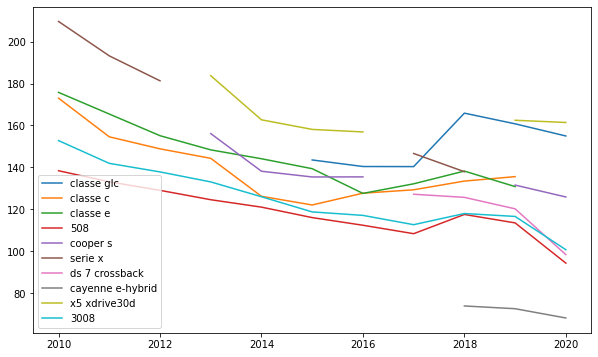

In [ ]:
print('top 25% engine capacity cars')

linegraph(emission_df)

In [ ]:
# top 10 models that has bottom 25% engine capacity('ec (cm3)' column) and their average Co2 Emission each year

emission_df = pd.DataFrame(columns = ['Cn'])
emission_df[[all_year]] = None

for name in country_df_engine_bottom_quartile['Cn'].value_counts()[:10].index:
    tmp_dict = dict()
    tmp_dict['Cn'] = name
    for year in all_year:
        mean_val = country_df.loc[(country_df['Cn'] == name) & (country_df['year'] == year), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

emission_df

,Cn,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,fiesta,124.5135,123.0000,118.7526,109.7768,105.5672,105.1697,104.8268,102.7346,112.8312,113.0417,101.1063
1,polo,120.9250,117.8182,118.3402,116.9639,110.2308,105.0111,103.8139,104.7614,105.1145,109.0853,109.4029
2,308,147.1087,140.9259,139.1000,130.5980,115.1930,106.1791,102.0357,104.8484,109.0325,106.5824,100.3757
3,corsa,124.3846,122.8489,122.2661,121.7699,121.1992,114.2386,114.5841,115.0295,126.7165,116.4733,88.5332
4,c3,124.7708,118.3191,116.3647,107.7702,102.7520,98.7561,97.2985,99.6593,108.2482,103.8495,97.5215
5,a1 sportback,NaN,NaN,113.6387,112.9652,113.1484,106.3558,105.1823,104.4373,109.3766,113.9852,113.4007
6,fabia,129.3134,117.7000,116.8943,115.0097,114.2865,106.8354,102.8519,104.8908,106.9873,106.6704,106.0511
7,clio,129.4477,124.5462,120.2052,109.0114,106.2647,104.5321,103.3259,104.1762,107.9751,106.4174,102.4114
8,focus,150.1954,135.3855,127.5490,123.6164,121.1768,117.2230,114.5126,113.6154,112.6935,115.9043,107.0488
9,ibiza,126.5976,120.7818,118.9226,118.2569,117.9333,112.7328,108.0545,107.3228,107.5809,107.8882,105.9794


bottom 25% engine capacity cars


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

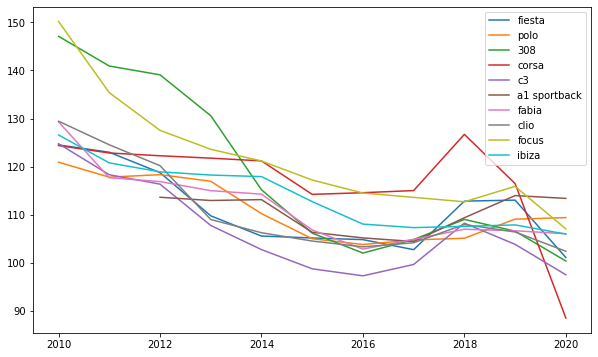

In [ ]:
print('bottom 25% engine capacity cars')

linegraph(emission_df)

In France, the decrease is both apparent in bigger and smaller models.

##### Brand analysis

- which brands were most registered in the country, and how's their Co2 emission?

In [ ]:
country_df['Mp'].value_counts()[:10]

vw group pc        140415
psa-opel           109359
bmw group           70724
daimler ag          55512
vw-saic             55441
bmw                 29347
renault             26418
ford-werke gmbh     25393
mercedes-benz       17874
ford-volvo          15707
Name: Mp, dtype: int64

In [ ]:
emission_df = pd.DataFrame(columns = ['Mp']) 
emission_df[[all_year]] = None

# for brand in country_df.loc[country_df['year']==2017, 'Mp'].value_counts()[:10].index:
for brand in country_df['Mp'].value_counts()[:10].index:

    tmp_dict = dict()
    tmp_dict['Mp'] = brand
    for year in all_year:
        mean_val = country_df.loc[(country_df['Mp'] == brand) & (country_df['year'] == year), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

country_most_brand[country_name] = emission_df['Mp']

emission_df

,Mp,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,vw group pc,NaN,161.0516,146.7222,139.4670,135.1282,129.2548,127.6121,126.3830,126.6427,131.2892,NaN
1,psa-opel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.3153,114.8452,102.9718
2,bmw group,NaN,NaN,155.8518,145.8230,139.8964,135.5383,132.9540,130.1357,126.0229,128.7220,NaN
3,daimler ag,NaN,176.4129,163.0817,153.3398,141.5175,138.6157,137.6433,136.0451,143.5296,142.4340,NaN
4,vw-saic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116.9392
5,bmw,172.8494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.4277
6,renault,NaN,NaN,NaN,NaN,NaN,119.5192,113.3344,114.7820,118.0345,123.2622,NaN
7,ford-werke gmbh,NaN,157.4891,143.4717,140.6271,129.3435,127.4010,126.7599,126.2303,123.7949,126.9200,NaN
8,mercedes-benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.9550
9,ford-volvo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.8098


Other than German brands, we see French brands such as psa opel and renault in the list

##### Fuel type analysis

In France, there is drastic decrease in diesel and increase in petrol. By 2020, the two types are almost similar in ratio.
And we see significant increase in petrol-electric type by 2020.

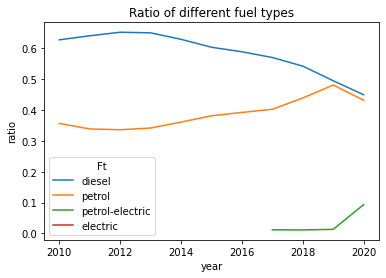

In [ ]:
ft_df = pd.DataFrame(country_df.groupby(by=['year', 'Ft'])['ID'].count() / country_df.groupby(by=['year'])['ID'].count()).reset_index()

country_dp_ratio[country_name] = ft_df.loc[ft_df['Ft']=='diesel', 'ID'].reset_index(drop=True) / ft_df.loc[ft_df['Ft']=='petrol', 'ID'].reset_index(drop=True)

ax = sns.lineplot(x = 'year', y = 'ID', hue='Ft', data=ft_df[ft_df['ID'] > 0.01])

ax.set( ylabel='ratio')
plt.title('Ratio of different fuel types')
plt.show()

#### Italy

In [ ]:
# Italy data only

country_name = 'it'
country_df = total_df[total_df['Country'] == country_name]

# removing unnecessary outliers
country_df = country_df[country_df['ec (cm3)'] < 10000]

##### Total cars, big vs small cars analysis

In [ ]:
# top 10 most registered cars and their average Co2 Emission each year

emission_df = pd.DataFrame(columns = ['Cn']) # car model name columns : Cn
emission_df[[all_year]] = None

for name in country_df['Cn'].value_counts()[:10].index:

    tmp_dict = dict()
    tmp_dict['Cn'] = name
    for year in all_year:
        mean_val = country_df.loc[(country_df['Cn'] == name) & (country_df['year'] == year), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

country_most_model[country_name] = emission_df['Cn']

emission_df

,Cn,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,tiguan,177.0149,163.2162,160.7031,157.0383,154.9636,149.9333,143.5786,144.4033,138.6023,137.7410,133.6405
1,fiat 500x,NaN,NaN,NaN,NaN,130.6667,132.2812,130.7229,124.1524,132.9821,128.5221,122.3687
2,golf,143.2099,142.0773,138.1672,120.9895,119.4592,113.7361,116.0511,118.7454,115.6238,116.9102,106.1934
3,focus,144.7167,134.0435,126.4121,122.9264,121.3208,115.2742,110.5932,108.6908,109.9384,111.7602,104.0385
4,polo,122.6481,120.7000,122.1220,122.2938,113.8611,104.1644,107.8235,104.8148,104.4631,108.1144,107.1886
5,renegade,NaN,NaN,NaN,NaN,140.1176,138.2500,136.5938,132.5909,141.7711,137.8804,125.5303
6,q3,NaN,NaN,160.8750,156.2414,152.7207,141.0233,135.3651,135.3540,135.3788,143.8531,136.6233
7,a4 avant,164.8784,150.1852,138.2300,137.7194,136.2661,130.9589,119.1400,116.5699,122.0716,124.5964,119.2495
8,a3 sportback,NaN,NaN,130.7049,119.5217,114.1149,113.5882,114.0000,114.1154,114.3029,118.9939,110.2377
9,t-roc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.3333,118.5604,123.5259,123.5975


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

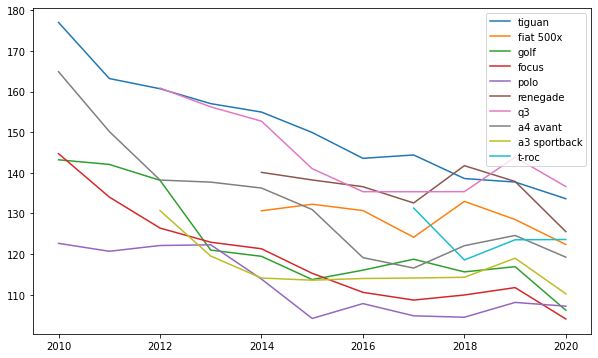

In [ ]:
linegraph(emission_df)

Above is the most registered models in Italy, and their average Co2 emission each year.

Top 5 models are 
- tiguan
- fiat 500x
- golf
- focus
- polo


In Italy, we see a definite overall decreasing trend over all models.

Below is the engine capacity(proxy for car size) distribution. 
We will conduct similar analysis on big(top 25%) and small(bottom 25%) cars seperately.

count   563144.0000
mean      1804.5698
std        589.0333
min          0.0000
25%       1496.0000
50%       1798.0000
75%       1995.0000
max       8285.0000
Name: ec (cm3), dtype: float64


<AxesSubplot:>

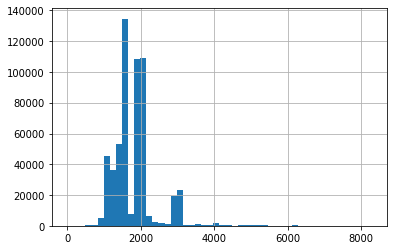

In [ ]:
print(country_df['ec (cm3)'].describe())
country_df['ec (cm3)'].hist(bins=50)

In [ ]:
top_quartile = country_df['ec (cm3)'].describe()['75%']
bottom_quartile = country_df['ec (cm3)'].describe()['25%']

country_df_engine_top_quartile = country_df[country_df['ec (cm3)'] > top_quartile]
country_df_engine_bottom_quartile = country_df[country_df['ec (cm3)'] < bottom_quartile]

In [ ]:
# top 10 models that has top 25% engine capacity('ec (cm3)' column) and their average Co2 Emission each year

emission_df = pd.DataFrame(columns = ['Cn'])
emission_df[[all_year]] = None

for name in country_df_engine_top_quartile['Cn'].value_counts()[:10].index:
    tmp_dict = dict()
    tmp_dict['Cn'] = name
    for year in all_year:
        mean_val = country_df.loc[(country_df['Cn'] == name) & (country_df['year'] == year), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

emission_df

,Cn,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,q8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,178.0563,179.8734,182.1971
1,stelvio,NaN,NaN,NaN,NaN,NaN,NaN,161.0000,137.3333,160.5130,154.4617,149.4046
2,a6 avant,189.1176,178.2000,152.8427,149.9661,148.3111,138.5109,133.8640,134.7442,146.5756,138.9415,134.0864
3,x5 xdrive30d,203.6667,197.2000,195.6000,186.5556,164.0909,158.6250,157.4545,166.7619,169.9102,162.4297,160.7368
4,range rover velar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.5455,169.5113,167.5655,NaN
5,jaguar e-pace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.2000,165.6408,164.5390,NaN
6,glc 250 d 4matic,NaN,NaN,NaN,NaN,NaN,135.8889,136.1373,136.5909,162.1118,162.5015,162.6970
7,touareg,236.6875,206.3667,206.5000,199.0312,203.2581,177.8462,190.0833,190.8000,173.0360,173.1611,175.3025
8,v-klasse,NaN,NaN,NaN,NaN,153.4500,159.5920,163.4882,165.0536,181.3594,175.4630,164.5463
9,range rover sport,282.3846,287.8889,257.8824,232.5000,216.5000,212.0000,204.7778,205.1373,202.6819,195.9900,NaN


top 25% engine capacity cars


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

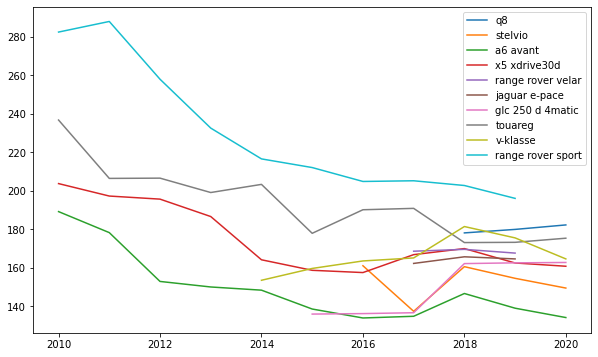

In [ ]:
print('top 25% engine capacity cars')

linegraph(emission_df)

In [ ]:
# top 10 models that has bottom 25% engine capacity('ec (cm3)' column) and their average Co2 Emission each year

emission_df = pd.DataFrame(columns = ['Cn'])
emission_df[[all_year]] = None

for name in country_df_engine_bottom_quartile['Cn'].value_counts()[:10].index:
    tmp_dict = dict()
    tmp_dict['Cn'] = name
    for year in all_year:
        mean_val = country_df.loc[(country_df['Cn'] == name) & (country_df['year'] == year), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

emission_df

,Cn,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,fiat 500x,NaN,NaN,NaN,NaN,130.6667,132.2812,130.7229,124.1524,132.9821,128.5221,122.3687
1,polo,122.6481,120.7000,122.1220,122.2938,113.8611,104.1644,107.8235,104.8148,104.4631,108.1144,107.1886
2,clio,130.1395,131.9554,124.3663,109.0947,105.6484,104.7756,102.6261,101.9262,107.4379,105.6000,100.3882
3,fiat 500,123.9062,121.6707,116.5397,109.3682,109.4854,106.3671,105.0088,105.8272,117.8778,115.0878,105.4394
4,a1 sportback,NaN,NaN,114.4714,112.4558,111.5000,105.2350,103.3881,104.4286,107.7154,112.9140,112.8206
5,fiesta,125.7949,123.8590,121.3587,112.4293,110.4315,107.3889,108.8690,104.6154,109.9888,111.1253,99.3641
6,fiat 500l,NaN,NaN,122.3333,117.1850,123.0261,120.5917,118.3929,119.4889,135.5271,133.4054,123.7766
7,a 180 d,NaN,NaN,NaN,NaN,NaN,101.8462,101.7619,101.0541,110.8601,108.3764,104.0843
8,corsa,125.3135,122.5565,123.3053,122.8630,122.4219,119.8308,118.3684,129.2500,126.0000,93.3659,93.9843
9,captur,NaN,NaN,NaN,107.0000,107.1607,105.2279,105.4565,106.4000,115.2108,119.0408,108.2993


bottom 25% engine capacity cars


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

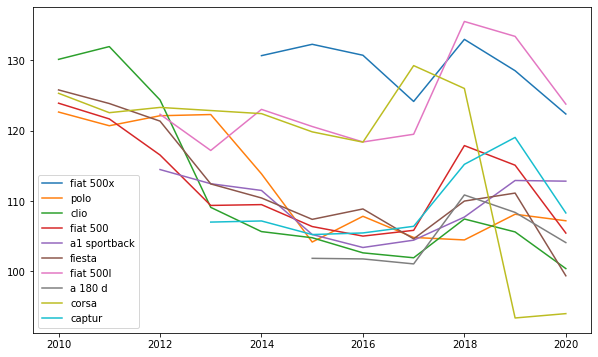

In [ ]:
print('bottom 25% engine capacity cars')

linegraph(emission_df)

Decreasing trend is more apprent in bigger cars. For smaller cars, there is a stagnation period
after 2014

##### Brand analysis

- which brands were most registered in the country, and how's their Co2 emission?

In [ ]:
country_df['Mp'].value_counts()[:10]

vw group pc        107180
bmw group           62479
vw-saic             52726
daimler ag          46979
psa-opel            45773
bmw                 26962
fca-tesla           23796
ford-werke gmbh     22195
mercedes-benz       16585
fca                 14179
Name: Mp, dtype: int64

In [ ]:
emission_df = pd.DataFrame(columns = ['Mp']) 
emission_df[[all_year]] = None

# for brand in country_df.loc[country_df['year']==2017, 'Mp'].value_counts()[:10].index:
for brand in country_df['Mp'].value_counts()[:10].index:

    tmp_dict = dict()
    tmp_dict['Mp'] = brand
    for year in all_year:
        mean_val = country_df.loc[(country_df['Mp'] == brand) & (country_df['year'] == year), 'Enedc (g/km)'].mean()
        tmp_dict[year] = mean_val    
    emission_df.loc[len(emission_df)] = tmp_dict

country_most_brand[country_name] = emission_df['Mp']

emission_df

,Mp,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,vw group pc,NaN,158.7056,152.1162,144.0055,140.6162,136.5440,132.7340,132.6805,129.4961,135.4890,NaN
1,bmw group,NaN,NaN,151.4792,144.2064,138.9944,130.9610,130.0035,132.8803,131.9425,127.8291,NaN
2,vw-saic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.6119
3,daimler ag,NaN,178.1084,164.5188,152.5389,146.5006,139.3706,139.2682,143.1817,146.0390,142.4459,NaN
4,psa-opel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.1979,115.6418,105.7112
5,bmw,171.3784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122.9192
6,fca-tesla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.4897,NaN
7,ford-werke gmbh,NaN,157.7158,144.0753,139.2696,132.7115,127.8262,126.2098,129.1833,126.9361,129.8960,NaN
8,mercedes-benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.1229
9,fca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.6510


Other than German brands, we see Italian brands such as fca in the list

##### Fuel type analysis

In Italy, in contrast to the general trend, diesel maintains the major fuel type overtime,
and the gap between diesel and petrol decreases only slightly. This is due to diesel's lower tax.

Also, in contrast to other countries, Italy shows more than 1% of fuel type ratio in lpg
and biomethane

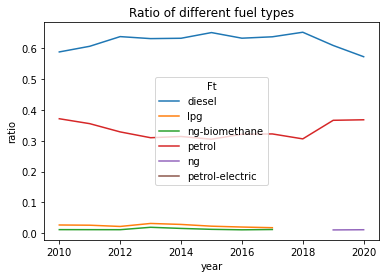

In [ ]:
ft_df = pd.DataFrame(country_df.groupby(by=['year', 'Ft'])['ID'].count() / country_df.groupby(by=['year'])['ID'].count()).reset_index()

country_dp_ratio[country_name] = ft_df.loc[ft_df['Ft']=='diesel', 'ID'].reset_index(drop=True) / ft_df.loc[ft_df['Ft']=='petrol', 'ID'].reset_index(drop=True)

ax = sns.lineplot(x = 'year', y = 'ID', hue='Ft', data=ft_df[ft_df['ID'] > 0.01])

ax.set( ylabel='ratio')
plt.title('Ratio of different fuel types')
plt.show()

#### Country Analysis Summary

##### Summary tables

Here are top 10 models in each country

In [ ]:
country_most_model

,de,gb,fr,it
0,golf,cooper,308,tiguan
1,tiguan,unknown,golf,fiat 500x
2,focus,cooper s,tiguan,golf
3,passat,megane,ds 7 crossback,focus
4,octavia,clio,classe c,polo
5,caddy,118i,3008,renegade
6,a4 avant,x5 xdrive30d,focus,q3
7,v-klasse,fiesta zetec,fiesta,a4 avant
8,polo,megane scenic,serie x,a3 sportback
9,touran,320d,5008,t-roc


Here are top 10 brands in each country

In [ ]:
country_most_brand 

,de,gb,fr,it
0,vw group pc,vw group pc,vw group pc,vw group pc
1,vw-saic,bmw group,psa-opel,bmw group
2,daimler ag,ford-werke gmbh,bmw group,vw-saic
3,bmw group,daimler ag,daimler ag,daimler ag
4,psa-opel,vw-saic,vw-saic,psa-opel
5,mercedes-benz,tata motors jaguar land rover,bmw,bmw
6,bmw,general motors,renault,fca-tesla
7,ford-werke gmbh,bmw,ford-werke gmbh,ford-werke gmbh
8,ford-volvo,psa-opel,mercedes-benz,mercedes-benz
9,general motors,ford-volvo,ford-volvo,fca


Here are diesel / petrol ratio in each country

In [ ]:
country_dp_ratio.index = all_year
country_dp_ratio

,de,gb,fr,it
2010,1.1856,1.2147,1.7593,1.5839
2011,1.2279,1.2618,1.8910,1.7067
2012,1.2016,1.4889,1.9393,1.9412
2013,1.1216,1.5159,1.9025,2.0387
2014,1.1066,1.4717,1.7433,2.0165
2015,1.0814,1.3417,1.5819,2.1351
2016,1.0593,1.3193,1.5012,1.9710
2017,1.0257,1.2069,1.4166,1.9790
2018,1.1079,1.0248,1.2348,2.1312
2019,1.0275,0.7511,1.0288,1.6630


##### Answering the 2 questions

So let's answer the 2 questions we asked ourselves in the beginning. The 2 questions can be answered together

(1) why Germany constantly has higher average Co2 emission?

(2) What happened to Great Britain that average Co2 emission jumped in 2019?

We will use engine capacity 'ec (cm3)' column for the proxy for the size of the car.
When comparing Germany and Great Britain, Germany has higher average size of cars. 
Although this applies to both petrol and diesel, the difference is greater in petrol.

Since the car size is highly correlated with Co2 emission(corr coefficient = 0.64), 
Germany naturally has higher average Co2 emission. So why did Germany emits higher average Co2? Because they drive larger vehicles. Simple

In [ ]:
de = total_df[total_df['Country'] == 'de']
gb = total_df[total_df['Country'] == 'gb']

de_petrol = de[de['Ft'] == 'petrol']
de_diesel = de[de['Ft'] == 'diesel']
gb_petrol = gb[gb['Ft'] == 'petrol']
gb_diesel = gb[gb['Ft'] == 'diesel']

de_petrol_engine = []
gb_petrol_engine = []
de_diesel_engine = []
gb_diesel_engine = []

for year in all_year:
    de_petrol_engine.append(de_petrol.loc[de_petrol['year'] ==year, 'ec (cm3)'].mean())
    gb_petrol_engine.append(gb_petrol.loc[gb_petrol['year'] ==year, 'ec (cm3)'].mean())
    de_diesel_engine.append(de_diesel.loc[de_diesel['year'] ==year, 'ec (cm3)'].mean())
    gb_diesel_engine.append(gb_diesel.loc[gb_diesel['year'] ==year, 'ec (cm3)'].mean())

<Figure size 432x288 with 0 Axes>

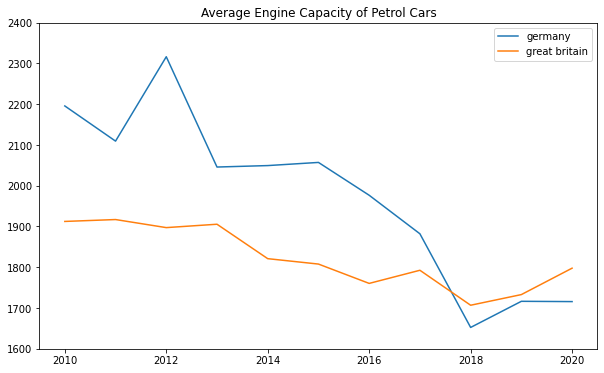

In [ ]:
fig = plt.figure()
plt.figure(figsize=(10, 6))


plt.plot(all_year, de_petrol_engine, label='germany')
plt.plot(all_year, gb_petrol_engine, label='great britain')

plt.ylim([1600, 2400])

plt.legend()
plt.title('Average Engine Capacity of Petrol Cars')
plt.show()

<Figure size 432x288 with 0 Axes>

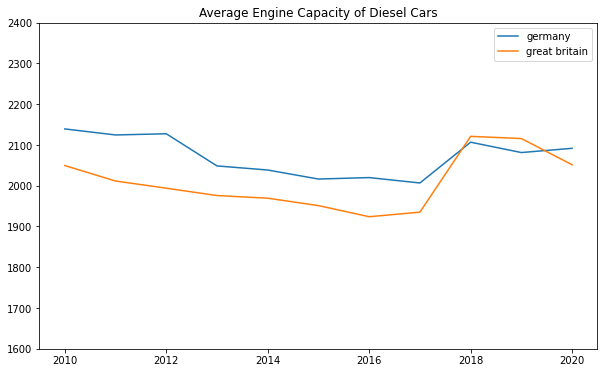

In [ ]:
fig = plt.figure()
plt.figure(figsize=(10, 6))


plt.plot(all_year, de_diesel_engine, label='germany')
plt.plot(all_year, gb_diesel_engine, label='great britain')

plt.ylim([1600, 2400])

plt.legend()
plt.title('Average Engine Capacity of Diesel Cars')
plt.show()

The graphs above also answer the second question. Why did Great Britain's average Co2 emission suddenly increase in 2018~2019?
In the graphs, there is increase in size around that time. Therefore, the second question can be answered simply. 
Why did average Co2 emission increase in Britain? Because they bought bigger cars